In [38]:
import numpy as np
import yaml
from matplotlib import pyplot as plt
import SimpleITK as sitk
from scipy.interpolate import RegularGridInterpolator


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I am re-writing the registration code from scratch because the coordinate transforms involved are too messy and it is hard to convert them back to the robot frame. 

I plan to utilize the transformation library from SimpleITK to methodically keep track of all the transformations made along the way, so that inverse transforms are easily doable.

# Coordinate Transform/Converion for 3D Images

## Coordinate conversion between continuous and pixel frames
- Typical assumption: the origin or continuous and pixel frames coincide.
- Pixel to continuous transform = Image Resolution. 
  - Data structure: np.array and sitk.Image. 
  - Functions: Interploation. sitk.GetImageFromArray, sitk.GetArrayFromImage, sitk_img.SetSpacing, sitk_img.SetOrigin. **sitk_img.TransformIndexToPhysicalPoint(), TransformPhysicalPointToIndex**.
  - Pixel to continuous transform conversion the pixel's distribution, but preserves the continuous relative positions.

## Coordinate transform between continuous and continuous frames
- Two ways of understanding coordinate transforms:
  - Fixed the underlying objects. Transform the coordinate frame from one pose to another.
  - Move/Transform the underlying objects, then re-naming the coordinate frame.
- Continuous to continuous transform = Affine transforms. Data structure: sitk.Image only. Functions: sitk.Transforms classes.

## Caveat: calling interpolation functions
Calling interploation functions can implicitly introduce a continuous transform. Look out for them. 


# Utility functions

In [39]:

def interp3(x,y,z,img_org, xr,yr,zr):
    """resampling"""
    
    xi,yi,zi = np.meshgrid(xr, yr, zr, indexing='ij')
    min_val = np.min(img_org)

    interp = RegularGridInterpolator((x,y,z),img_org,bounds_error=False,fill_value=min_val)
    img = interp( (xi,yi,zi)).astype(np.float32)
    
    return img


def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz
   
def plot_slice(ploting_ax, img,slice,axis):
    '''
        Plot img along a specific axis.
    '''

    if axis==0:
        ploting_ax.imshow(img[slice])
    elif axis==1:
        ploting_ax.imshow(img[:,slice,:])
    elif axis==2:
        ploting_ax.imshow(img[:,:,slice])
    return ploting_ax

def plot_img_at(img, coord, label='Target Location'):
    '''
        Plot the 3D slicing view of img at coord.
    '''

    l,p,s = coord
    
    axis_label ={"L":"L: left to right",
                 "P":"P: front to back",
                 "S":"S: feet to head"}
    
    target_marker = 'x'
    target_size = 50
    target_color = 'red'

    ax = plt.subplot(1, 3, 1)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["P"])
    ax.set_ylabel(axis_label["S"])
    ax.invert_yaxis()

    ax.imshow(np.squeeze(img[l,:,:]).T)
    ax.scatter(p,s,marker = target_marker,s=target_size,label=label,color = target_color)
    ax.legend()

    ax = plt.subplot(1, 3, 2)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["L"])
    ax.set_ylabel(axis_label["S"])
    ax.invert_yaxis()

    
    ax.imshow(np.squeeze(img[:,p,:]).T)
    ax.scatter(l,s,marker = target_marker,s=target_size,color = target_color)
    
    

    ax = plt.subplot(1, 3, 3)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["L"])
    ax.set_ylabel(axis_label["P"])
    ax.invert_yaxis()


    ax.imshow(np.squeeze(img[:,:,s]).T)
    ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color)
    
    
    return ax
def sitk2numpy(sitk_img):
    '''
        Return a numpy array that has the same shape as the sitk image.
    '''
    out = (sitk.GetArrayFromImage(sitk_img)).astype(np.float32)
    return out


# 3D Registration

In [40]:
from tqdm import trange

In [41]:
def central_normalize_img(input_img,n_side = 200):
    '''
        input_img: a sitk.Image object. 
        
        Crop and centralize the non-zero voxels of the image.
    '''
    img = sitk.GetArrayViewFromImage(input_img)
    img = np.swapaxes(img,0,2)
    centroid_pixel = centroid3(img)
    centroid_physical = input_img.TransformContinuousIndexToPhysicalPoint(list(centroid_pixel))

    ref_dx, ref_dy, ref_dz = 1.0, 1.0, 1.0
    ref_nx, ref_ny, ref_nz = n_side, n_side, n_side # Keep the grid size smaller than 150x150x150 for efficient computation
    
    output_origin = centroid_physical-np.array([ref_nx, ref_ny, ref_nz])/2 

    output_spacing = [ref_dx,ref_dy,ref_dz]

    # The number of voxels in the output
    output_size = [ref_nx,ref_ny,ref_nz]

    return normalize_img(input_img, output_origin, output_spacing, output_size)

def normalize_img(input_img, output_origin, output_spacing, output_size):
    '''
        input_img: a sitk.Image object. 

        output_origin: float vector. The physical point coordinate corresponding to index (0,0,0) of the output image.
        output_spacing: float vector. The physical distance between adjacent voxels of the output image.
        output_size: int vector. The number of voxels in each dimension of the output image.
    '''
    identity_tf = sitk.Euler3DTransform() # We only crop and change the resolution of the image. No spatial transform is needed.

    output = sitk.Resample(input_img,output_size, identity_tf, sitk.sitkLinear,output_origin,output_spacing)
    return output

def visualize_vessel(vessel_img):
    img = sitk.GetArrayViewFromImage(vessel_img)
    img = np.swapaxes(img,0,2)
    target_pixel = np.array(centroid3(img) + np.array([0,0,0]))
    plt.figure(figsize=(15,6))
    plot_img_at(img,np.array(target_pixel,dtype=int),label='Centroid location')
    plt.show()

def get_centroid_loc(vessel_img):
    img = sitk.GetArrayViewFromImage(vessel_img)
    img = np.swapaxes(img,0,2)
    target_pixel = np.array(centroid3(img) + np.array([0,0,0]))
    return np.array(vessel_img.TransformContinuousIndexToPhysicalPoint(target_pixel))
    

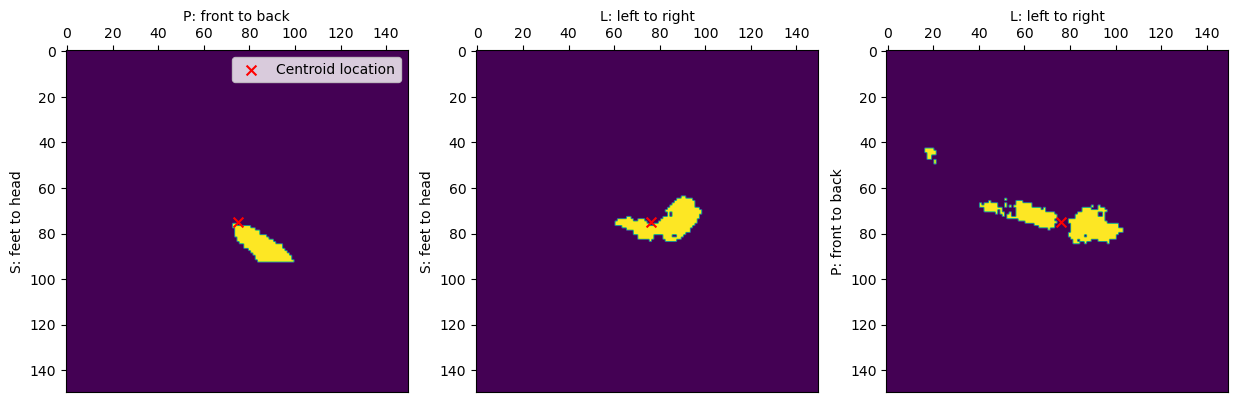

In [67]:
vessel_ct = sitk.ReadImage('vessel_ct.nii.gz')
vessel_ct = central_normalize_img(vessel_ct,150)


# The left-right order is different between the US image and CT image. We flip vessel_ct to make them consistent.
flipped_ct = sitk.Flip(vessel_ct,[True, False, False])
flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
flipped_ct.SetOrigin(vessel_ct.GetOrigin())
flipped_ct.SetSpacing(vessel_ct.GetSpacing())
vessel_ct = flipped_ct

visualize_vessel(vessel_ct)

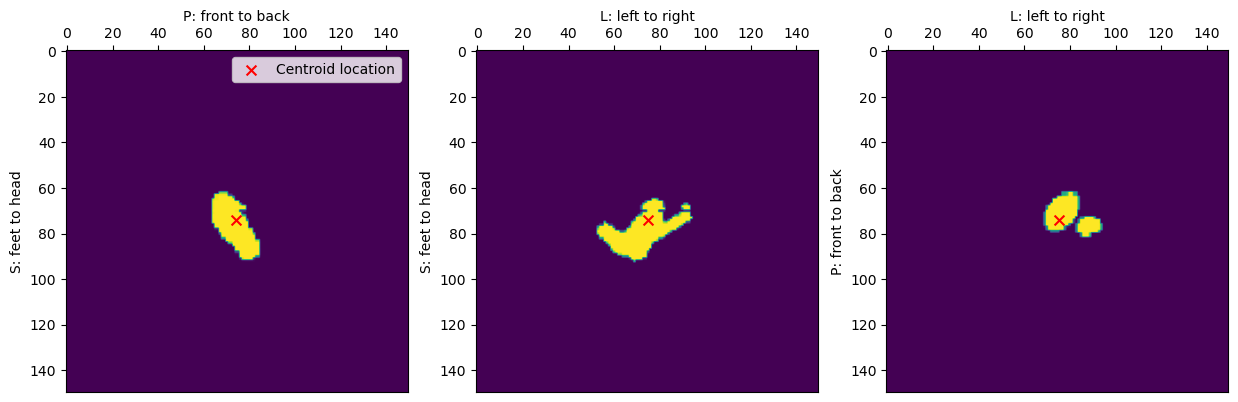

In [68]:
## resampling reference size and resolution
vessel_us = sitk.ReadImage('vessel_us.nii.gz')
vessel_us = central_normalize_img(vessel_us,150)
visualize_vessel(vessel_us)

In [69]:
sitk.WriteImage(vessel_us,'vessel_us_resample.nii.gz')
sitk.WriteImage(vessel_ct,'vessel_ct_resample.nii.gz')

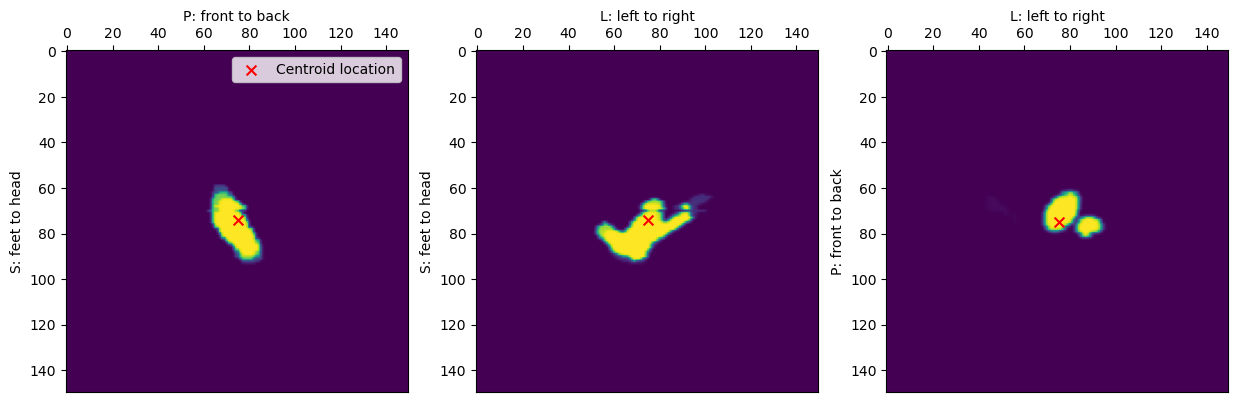

In [70]:
# shifted_us 
# centroid_offset = sitk.TranslationTransform(3, -us_centroid_physical+ct_centroid_physical)
# shifted_us_plus = sitk.Resample(vessel_us, centroid_offset)
# visualize_vessel(shifted_us_plus)
# sitk.WriteImage(shifted_us_plus,'shifted_us_plus.nii.gz')
us_centroid_physical = get_centroid_loc(vessel_us)
ct_centroid_physical = get_centroid_loc(vessel_ct)
centroid_offset = sitk.TranslationTransform(3, us_centroid_physical-ct_centroid_physical)
shifted_us = sitk.Resample(vessel_us,vessel_ct, centroid_offset)
shifted_us = central_normalize_img(shifted_us,150)

sitk.WriteImage(shifted_us,'shifted_us.nii.gz')
visualize_vessel(shifted_us)


In [71]:
## https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

# Some type casting is needed on the vessel_ct for the registration code to work
fixed_image = sitk.GetImageFromArray(sitk.GetArrayFromImage(vessel_ct).astype(np.float64))
fixed_image.SetOrigin(vessel_ct.GetOrigin())
fixed_image.SetSpacing(vessel_ct.GetSpacing())

moving_image = shifted_us

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
num_iter = 10
print('Start optimizing the transformation')
for ii in trange(num_iter):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=20)
    registration_method.SetMetricSamplingStrategy(registration_method.REGULAR )
    registration_method.SetMetricSamplingPercentage(0.2)    
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=30, convergenceMinimumValue=1e-7, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    
    # Don't optimize in-place. We want to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    rigid_transform = registration_method.Execute(fixed_image, moving_image)

moving_reg = sitk.Resample(moving_image,fixed_image, rigid_transform)
sitk.WriteImage(moving_reg,'vessel_reg.nii.gz')


Start optimizing the transformation


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


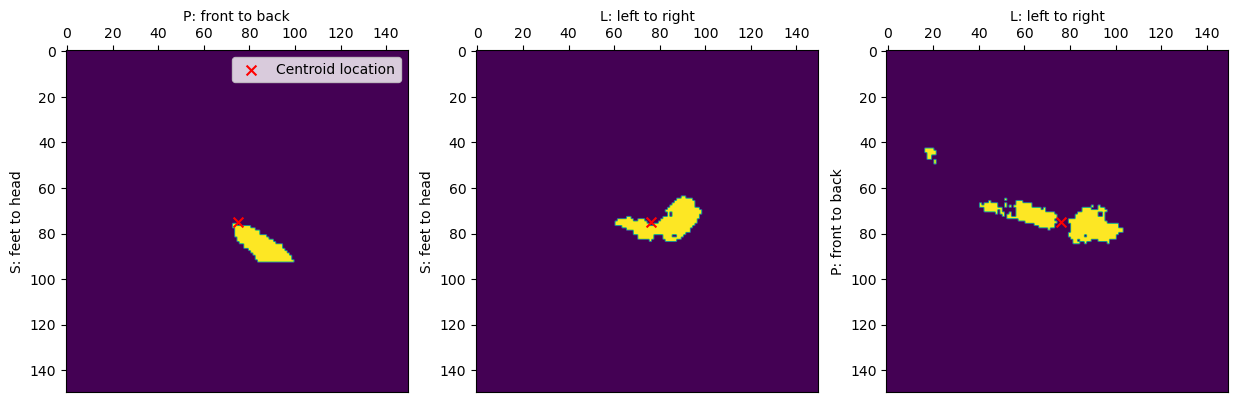

In [72]:
visualize_vessel(fixed_image)

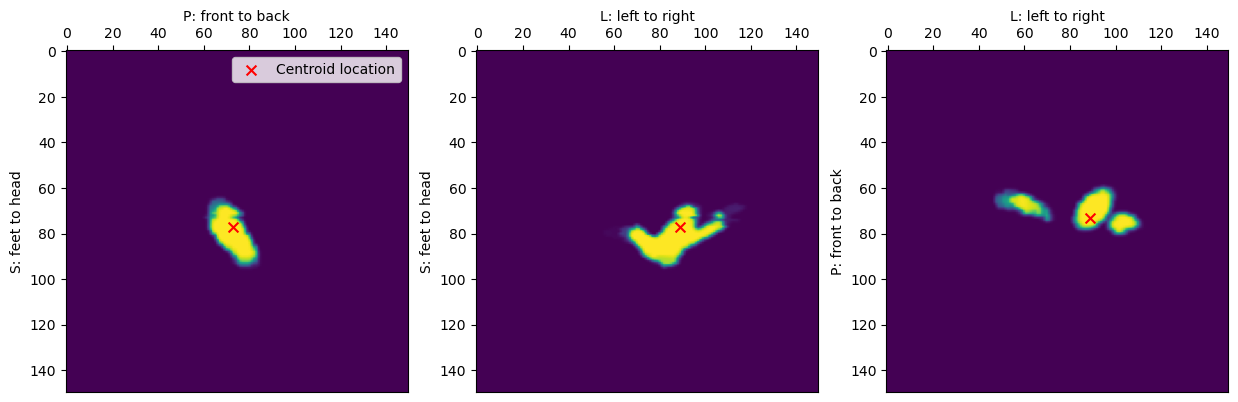

In [73]:
visualize_vessel(moving_reg)

# Visualize registration result

In [45]:
def getCenterCoord(sitk_img):
    '''
        Assumption: the origins of continuous and pixel coordinate of sitk_img coincide.

        Output: the continuous coordinate of the center of a sitk_img in sitk_img's frame.
    '''
    return pixel2loc(np.array(sitk_img.GetSize())/2,sitk_img.GetSpacing())

In [53]:
ct_center = getCenterCoord(vessel_ct)
resampled_ct_center = getCenterCoord(fixed_image)
CT2ResampledCT = sitk.TranslationTransform(3, resampled_ct_center-ct_center)

In [58]:
us_center = getCenterCoord(vessel_us)
resampled_us_center = getCenterCoord(moving_image)
diffs = np.array([diff_x,diff_y,diff_z])
refs = np.array([ref_dx,ref_dy,ref_dz])

US2ResampledUS = sitk.TranslationTransform(3,resampled_us_center-us_center-diffs*refs)

In [62]:
img_us_move_centroid.shape

(100, 100, 100)

In [ ]:
sitk.Resample(ves,)

In [51]:
CT2ResampledCT.TransformPoint(ct_center)

(50.0, 50.0, 50.0)

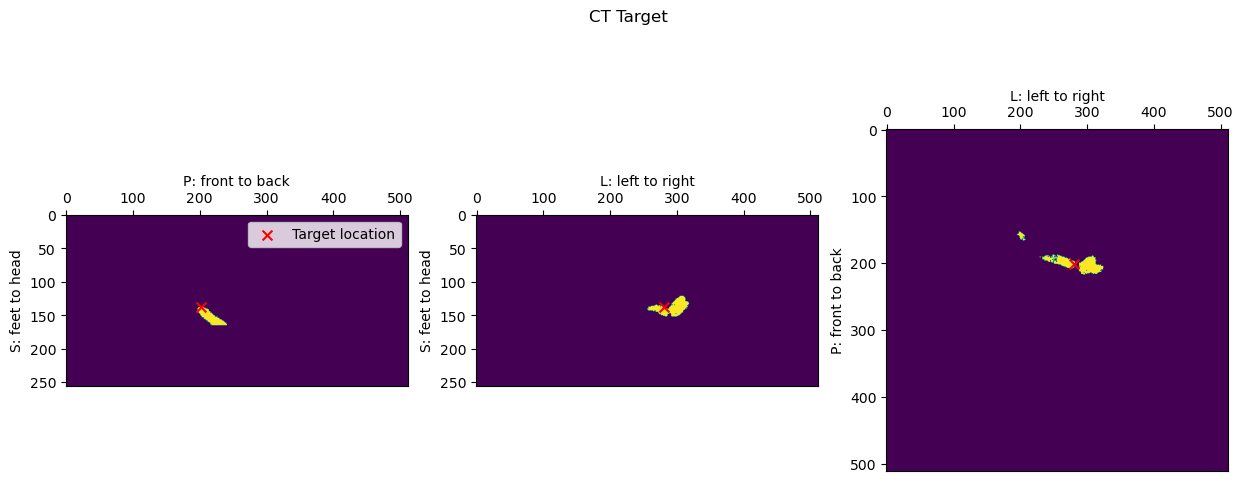

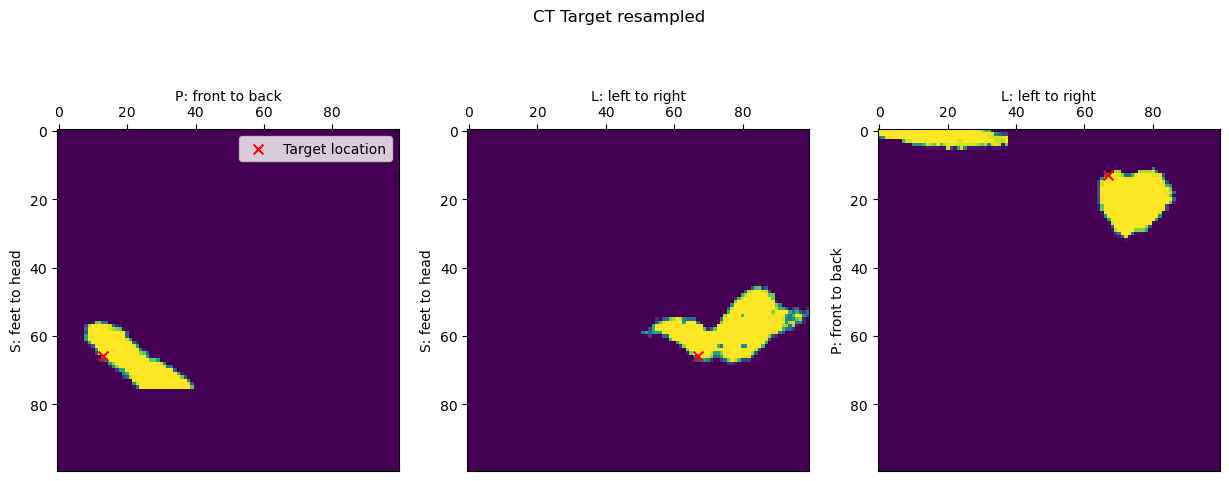

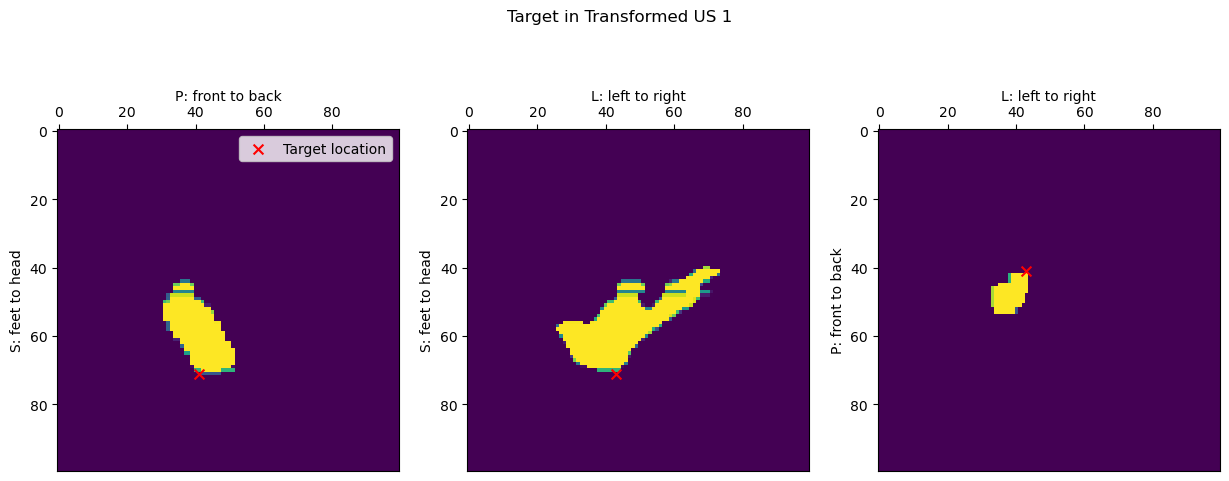

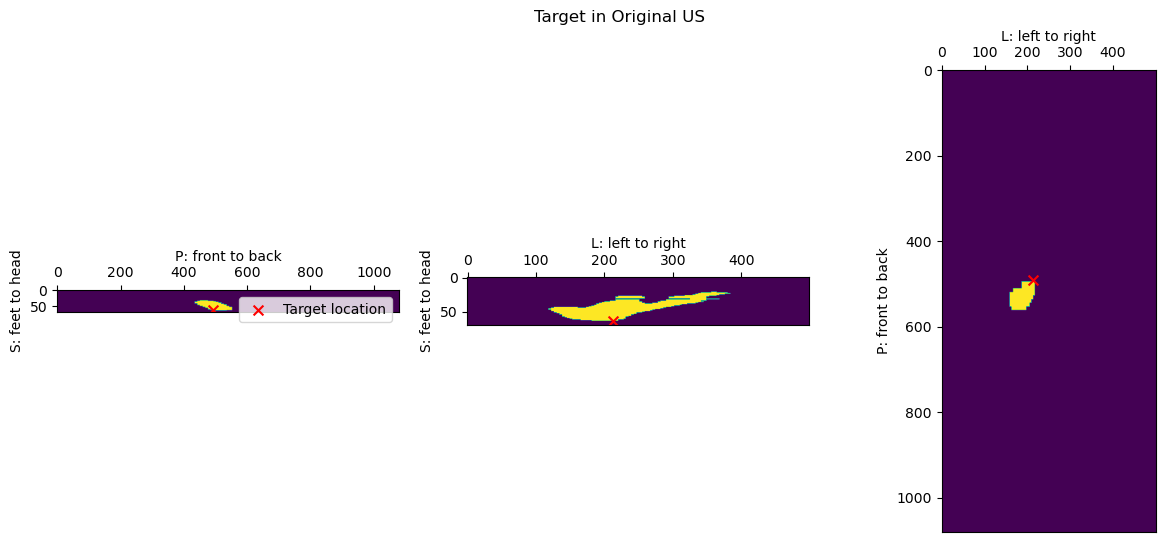

In [7]:

target_pixel = np.array(centroid3(tmp_ct_img) + np.array([0,0,0]),dtype=int)
plt.figure(figsize=(15,6))
plot_img_at(tmp_ct_img,target_pixel)
plt.suptitle("CT Target")
plt.show()



target_loc = centroid3(img_ct_final)+ np.array([0,0,6])
target_pixel = loc2pixel(target_loc,fixed_image.GetSpacing())

plt.figure(figsize=(15,6))
plot_img_at(img_ct_final,target_pixel)
plt.suptitle("CT Target resampled")
plt.show()

inv = rigid_transform.GetInverse()
us_loc_1 = inv.TransformPoint(target_loc.astype(float))
us_loc_1 += np.array([diff_x,diff_y,diff_z])
us_pixel_1 = loc2pixel(us_loc_1,moving_image.GetSpacing())

plt.figure(figsize=(15,6))
plot_img_at(us_img_1,us_pixel_1)
plt.suptitle("Target in Transformed US 1")
plt.show()


us_loc_0 = pixel2loc(us_pixel_1 - np.array(us_img_1.shape)/2,moving_image.GetSpacing())
us_pixel_0 = loc2pixel(us_loc_0,us_res)+np.array(us_img_0.shape)//2
plt.figure(figsize=(15,6))
plot_img_at(us_img_0,us_pixel_0)
plt.suptitle("Target in Original US")
plt.show()

[27  3 66]


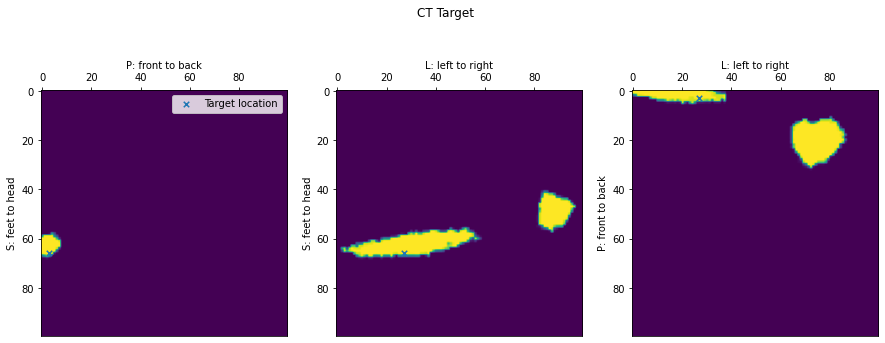

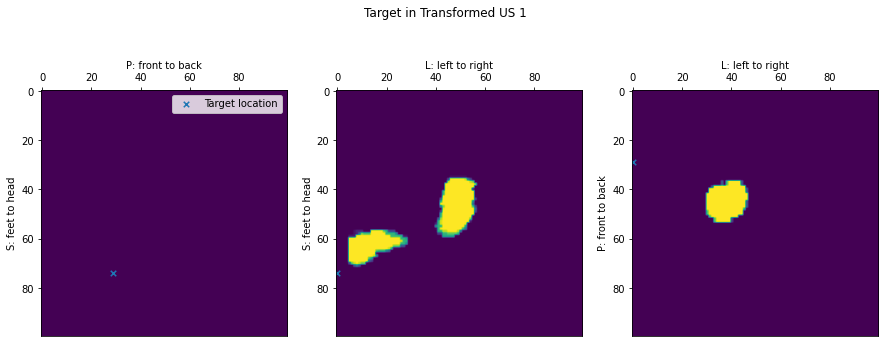

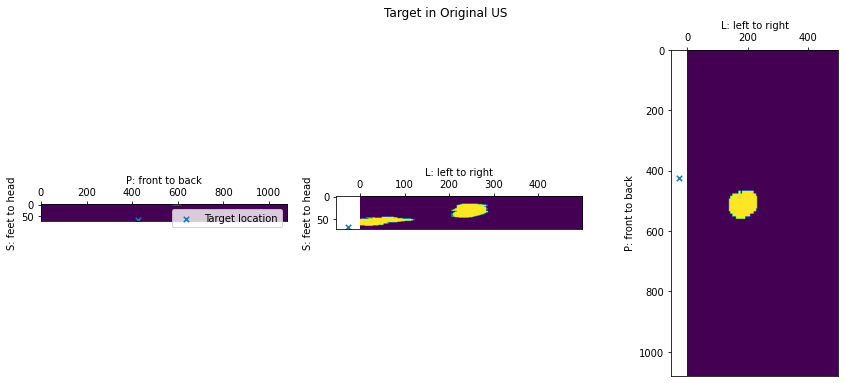

In [23]:

target_loc = centroid3(img_ct_final)+ np.array([-40,-10,6])
# target_loc = np.array(centroid3(img_ct_final))
target_pixel = loc2pixel(target_loc,fixed_image.GetSpacing())
print(target_pixel)
plt.figure(figsize=(15,6))
plot_img_at(img_ct_final,target_pixel)
plt.suptitle("CT Target")
plt.show()

inv = rigid_transform.GetInverse()
us_loc_1 = inv.TransformPoint(target_loc.astype(float))
us_loc_1 += np.array([diff_x,diff_y,diff_z])
us_pixel_1 = loc2pixel(us_loc_1,moving_image.GetSpacing())

plt.figure(figsize=(15,6))
plot_img_at(us_img_1,us_pixel_1)
plt.suptitle("Target in Transformed US 1")
plt.show()


us_loc_0 = pixel2loc(us_pixel_1 - np.array(us_img_1.shape)/2,moving_image.GetSpacing())
us_pixel_0 = loc2pixel(us_loc_0,us_res)+np.array(us_img_0.shape)//2
plt.figure(figsize=(15,6))
plot_img_at(us_img_0,us_pixel_0)
plt.suptitle("Target in Original US")
plt.show()

In [15]:
pipeline.stop()

In [9]:
ultrasoud_vid.release()

# Clean up

In [37]:
ultrasoud_vid.release()
pipeline.stop()

# Useful Scripts

In [4]:
# Script for saving default pose
with open('../../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)